In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import numpy as np
import sys
import time
import math
import pandas as pd
import copy
from sklearn.utils.validation import check_X_y
from sklearn.ensemble import RandomForestClassifier 
from honest_forests.estimators import HonestForestClassifier
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

In [6]:
def Posterior_After(X,v,X_sample,tree_i):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(X_sample.shape[0],1))
    
    ### Replace test data with values from structure subset   
    X_variable = X_sample[:,v]
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(tree_i.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(tree_i.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

In [7]:
def SCORE(tree_i,X,y):
    X_structure = X[tree_i.structure_indices_]
    X_honest = X[tree_i.honest_indices_]
    y_honest  = y[tree_i.honest_indices_]
        
    leaves_indicies_before = tree_i.tree_.apply(X_honest.astype(np.float32))
    value_leaves_before = tree_i.tree_.value[leaves_indicies_before]
    classification_before = np.zeros(X_honest.shape[0])
    #error_before = np.zeros((X_honest.shape[0],1))
        
    posterior_proba_before = np.zeros((X_honest.shape[0],2))##n_classes
    value_leaves = np.zeros((X_honest.shape[0],2))
    posterior_proba = np.zeros((X_honest.shape[0],2))
    classification_after = np.zeros(X_honest.shape[0])
    difference_clf = np.zeros(X_honest.shape[0])
    #error_after = np.zeros((X_honest.shape[0],1))
        
    mean_diff = np.zeros(X_honest.shape[1])
    feature_org = pd.unique(tree_i.tree_.feature)
    feature = feature_org[feature_org>=0]
    print(feature)
    for k in feature:
        print(k)
        for i in range(0,X_honest.shape[0]):
            ##Compute posterior probability before merging
            posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])
            ##Compute posterior probability after merging
            value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k,X_structure,tree_i)
            #Compute the difference of posterior possibility for just one class
            
        ## Get the classification_before result
        classification_before = posterior_proba_before.argmax(1)
        #print(classification_before)
        ## Get the classification_after result
        classification_after = posterior_proba.argmax(1)
            
        #Calculate classification error before 
        error_before = np.mean(np.abs(y_honest - classification_before))
        #Calculate classification error after merging leaves
        error_after = np.mean(np.abs(y_honest - classification_after))
        #Calculate the difference of classification error
        difference_clf = error_after - error_before
        mean_diff[k] = difference_clf
    return mean_diff

In [8]:
def Permutation(X,y,CLASSIFIER):
    Y_predict_before = CLASSIFIER.predict(X)
    predict_error = np.mean(np.abs(Y_predict_before-y))
    feature = []
    for tree_i in CLASSIFIER.estimators_:
        feature_org_i = pd.unique(tree_i.tree_.feature)
        feature_i = feature_org_i[feature_org_i>=0]
        feature = pd.unique([int(x) for x in pd.unique(np.append(feature,feature_i))])
    permutation_score = np.zeros(X.shape[1])
    for k in feature:
        #print(k)
        score_k = []
        for i in range(0,5):
            #print(X[:,k])
            X_k = copy.copy(X)
            #print(X_k)
            X_k[:,k] = shuffle(X[:,k])
            #print(X_k[:,k])
            #print(X[:,k])
            Y_predict_after = CLASSIFIER.predict(X_k)
            predict_error_after = np.mean(np.abs(Y_predict_after-y))
            #print(predict_error_after)
            score_k = np.append(score_k,predict_error_after-predict_error)
        permutation_score[k] = np.mean(score_k)
    print(permutation_score)
    return permutation_score
            


In [9]:
Data = pd.read_csv("GSE99095_normalizedExpression.csv")
Data_gene = Data.iloc[:,0]
Data_GES = Data.iloc[:,1:].T
print(Data_GES)

                0         1         2         3         4         5      \
H2_cell_1   -1.902811  0.012077  0.253047  0.879212 -3.412424  1.545093   
H2_cell_2   -1.826095  0.032311 -2.032669  0.612235 -3.283237  0.673663   
H2_cell_7   -1.767776  0.155079  1.010954  0.897366 -1.175463  0.913850   
H2_cell_8   -1.939080  1.227246  0.684497  1.128768  1.866054  0.776755   
H2_cell_12  -2.467119  0.414571 -0.364441  0.511028  0.497678  0.285301   
...               ...       ...       ...       ...       ...       ...   
P7_cell_218 -2.061681  1.018671 -1.799021  0.966253  0.420283  0.329679   
P7_cell_219 -2.148045 -0.100947  2.272544  0.202707 -0.229254  0.319999   
P7_cell_220 -2.171899 -5.069060 -5.101365 -5.063417 -5.649684 -3.306641   
P7_cell_245 -1.528971  1.255883 -4.458437  2.382207  3.412130  1.966724   
P7_cell_249 -1.568009  2.234874  2.451141  1.692975  1.763232  0.559262   

                6         7         8         9      ...     17248     17249  \
H2_cell_1    2.2200

In [11]:
idx_hp = np.argwhere(np.array(list(map(lambda x: x.find('H'), Data_GES._stat_axis.values.tolist())))==0)
Data_GES['H/P'] = 1
print(idx_hp.ravel().shape)
Data_GES['H/P'][idx_hp.ravel()] = 0
print(Data_GES)

(391,)
                    0         1         2         3         4         5  \
H2_cell_1   -1.902811  0.012077  0.253047  0.879212 -3.412424  1.545093   
H2_cell_2   -1.826095  0.032311 -2.032669  0.612235 -3.283237  0.673663   
H2_cell_7   -1.767776  0.155079  1.010954  0.897366 -1.175463  0.913850   
H2_cell_8   -1.939080  1.227246  0.684497  1.128768  1.866054  0.776755   
H2_cell_12  -2.467119  0.414571 -0.364441  0.511028  0.497678  0.285301   
...               ...       ...       ...       ...       ...       ...   
P7_cell_218 -2.061681  1.018671 -1.799021  0.966253  0.420283  0.329679   
P7_cell_219 -2.148045 -0.100947  2.272544  0.202707 -0.229254  0.319999   
P7_cell_220 -2.171899 -5.069060 -5.101365 -5.063417 -5.649684 -3.306641   
P7_cell_245 -1.528971  1.255883 -4.458437  2.382207  3.412130  1.966724   
P7_cell_249 -1.568009  2.234874  2.451141  1.692975  1.763232  0.559262   

                    6         7         8         9  ...     17249     17250  \
H2_cell_1   

In [12]:
X_train = Data_GES.iloc[:,:-1]
train_set,test_set = train_test_split(Data_GES,test_size = 0.2,random_state = 0)

X_train = np.array(train_set.iloc[:,:-1])
y_train = np.array(train_set.iloc[:,-1])
X_train.shape
y_train.shape

(783,)

In [16]:
##Compute feature importance from FIMs

N = 1
d = X_train.shape[1]
n_estimator = 100

score_hf = np.zeros((N,d))## HFIM
#Calculter Permutation Based HF socre
score_hfp = np.zeros((N,d))## Permutation FIM with honest forest

#Calculter Permutation Based RF socre
score_rfp = np.zeros((N,d))
error = [] 
error_rf = []
for num in range(0,N):
    print(num)
    #Train an Honest Tree
    ###We find that the honest tree nust be full trained？
    ###there will be difference for the rank of feature imporatnces  
    #t_ht = time.time()
    Data = shuffle(Data_GES)
    train_set,test_set = train_test_split(Data,test_size = 0.2,random_state = 0)

    X_train = np.array(train_set.iloc[:,:-1])
    y_train = np.array(train_set.iloc[:,-1])

    X_test = np.array(test_set.iloc[:,:-1])
    y_test = np.array(test_set.iloc[:,-1])
    
    tic_hf = time.time()
    clf = HonestForestClassifier(honest_fraction = 0.3, n_estimators = n_estimator,max_features = d,bootstrap = False)
    clf = clf.fit(X_train, y_train)
    toc_hf = time.time()
    print("finish")
    y_predict = clf.predict(X_test)
    predict_error = np.mean(np.abs(y_test-y_predict))
    error = np.append(error,predict_error)
    print(toc_hf-tic_hf)
    print("finish")
    print("prediction error" + str(predict_error))
    
    
    tic_1 = time.time()
    # score_tree = np.zeros((n_estimator,d))
    # num_tree = 0
    
    score_tree = Parallel(n_jobs=-1)(delayed(SCORE)(tree_i,X_train,y_train) for tree_i in (clf.estimators_))
    # for tree_i in clf.estimators_:
        
    #     score_tree_i = SCORE(tree_i,X_train,y_train)
    #     score_tree[num_tree,:] = score_tree_i
    #     num_tree = num_tree+1
    #     print(num_tree)

    #Save HF socre
    score_hf[num,:] = np.mean(score_tree,axis = 0)
    toc_1 = time.time()
    print("TIME_HF " + str(toc_1-tic_1))
    
    tic_2 = time.time()
    r_hf = Permutation(X_train,y_train,clf)
    score_hfp[num,:] = r_hf
    toc_2 = time.time()
    print("TIME_HFP" + str(toc_2-tic_2))
    
    tic_rf = time.time()
    clf_rf = RandomForestClassifier(n_estimators = n_estimator,max_features = d,bootstrap = False)
    clf_rf = clf_rf.fit(X_train, y_train)
    toc_rf = time.time()
    print("finish")
    y_predict_rf = clf_rf.predict(X_test)
    predict_error_rf = np.mean(np.abs(y_predict_rf-y_test))
    error_rf = np.append(error_rf,predict_error_rf)

    print("finish")
    print("prediction error" + str(predict_error_rf))
    
    tic_3 = time.time()
    r_rf = Permutation(X_train,y_train,clf_rf)
    score_rfp[num,:] = r_rf
    toc_3 = time.time()
    print("TIME_RF" + str(toc_rf-tic_rf))
    print("TIME_RFP" + str(toc_3-tic_3))

    num += 1
    
 

0
finish
393.4749994277954
finish
prediction error0.02040816326530612


In [ ]:
np.save('FIM_HF_Score_GES_5Iteration3.npy',score_hf)

In [38]:
np.save('FIM_HF_Score_GES_5Iteration4_withRF.npy',score_hf)

average width of 95% CI of HFIM Score is nan
average width of 95% CI of HFIM Score is nan


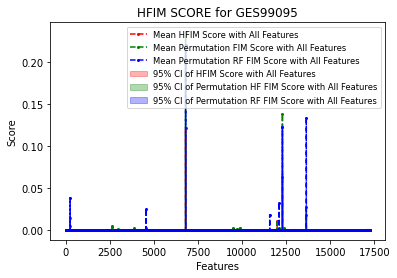

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: Runt

In [15]:
score_hf_mean = np.mean(score_hf,axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hfp,axis = 0), scale=stats.sem(score_hfp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_hf_mean,'r--',marker='o', markersize=2,label = 'Mean HFIM Score with All Features')
plt.fill_between(np.arange(1,d+1,1),ci_hf_low,ci_hf_up,alpha = 0.3,color = 'red',label = '95% CI of HFIM Score with All Features')
width_hf = np.mean(ci_hf_up-ci_hf_low)
print("average width of 95% CI of HFIM Score is " + str(width_hf))


score_hfp_mean = np.mean(score_hfp,axis = 0)
ci_hfp_low,ci_hfp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hfp,axis = 0), scale=stats.sem(score_hfp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_hfp_mean,'g--',marker='o', markersize=2,label = 'Mean Permutation FIM Score with All Features')
plt.fill_between(np.arange(1,d+1,1),ci_hfp_low,ci_hfp_up,alpha = 0.3,color = 'green',label = '95% CI of Permutation HF FIM Score with All Features')
width_hf = np.mean(ci_hfp_up-ci_hfp_low)
print("average width of 95% CI of HFIM Score is " + str(width_hf))


score_rfp_mean = np.mean(score_rfp,axis = 0)
ci_rfp_low,ci_rfp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_rfp,axis = 0), scale=stats.sem(score_rfp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_rfp_mean,'b--',marker='o', markersize=2,label = 'Mean Permutation RF FIM Score with All Features')
plt.fill_between(np.arange(1,d+1,1),ci_rfp_low,ci_rfp_up,alpha = 0.3,color = 'blue',label = '95% CI of Permutation RF FIM Score with All Features')
width_hf = np.mean(ci_hfp_up-ci_hfp_low)



plt.xlabel('Features')
plt.ylabel('Score')
plt.legend(loc = 'upper right',fontsize = 'small')
plt.title('HFIM SCORE for GES99095')
#plt.savefig('95% CI of FIM Score with 500 Train Samples',bbox_inches = 'tight')
plt.show()

In [29]:
np.where(score_hf_mean > 0)

(array([   13,    24,    75,   131,   286,   409,   554,   679,   703,
          838,   962,  1044,  1136,  1245,  1259,  1666,  1742,  1763,
         1773,  1802,  1833,  1853,  2051,  2058,  2061,  2332,  2533,
         2562,  2592,  2648,  2652,  2731,  2782,  2790,  2879,  2882,
         3074,  3242,  3268,  3291,  3406,  3594,  3711,  3801,  3870,
         3890,  4152,  4189,  4325,  4385,  4524,  4560,  4721,  4773,
         4919,  4999,  5025,  5078,  5500,  5511,  5540,  5619,  5631,
         5757,  5791,  5802,  5964,  6356,  6369,  6458,  6477,  6478,
         6498,  6637,  6704,  6800,  6835,  6960,  6971,  7075,  7260,
         7413,  7465,  7543,  7611,  7612,  7696,  7708,  7879,  7884,
         7891,  7923,  8099,  8208,  8215,  8433,  8579,  8610,  8639,
         8756,  8802,  8892,  8952,  8954,  8975,  8995,  9063,  9067,
         9233,  9235,  9407,  9541,  9600,  9645,  9767,  9912, 10039,
        10258, 10333, 10549, 10596, 10602, 10634, 10751, 10826, 10840,
      

In [30]:
np.where(score_hfp_mean > 0)

(array([   24,   679,   700,  1853,  2533,  2608,  2648,  2652,  2782,
         2882,  3268,  3291,  3479,  3890,  4082,  4095,  4325,  4385,
         4524,  4560,  4577,  4795,  4919,  5543,  5619,  5631,  5757,
         6458,  6477,  6478,  6800,  6835,  7075,  7465,  7611,  7848,
         8579,  8639,  8736,  8802,  8975,  9366,  9541,  9912, 10039,
        10168, 10549, 10596, 10786, 10845, 11046, 11782, 11785, 11913,
        11987, 12103, 12290, 12405, 12495, 13573, 13643, 13867, 14529,
        15097, 15678, 16089, 16444, 16761, 16774, 17231]),)

In [31]:
np.where(score_rfp_mean > 0)

(array([ 2648,  6800, 12290, 12495, 13643]),)

In [91]:
stats.rankdata(score_hf_mean,method = 'max')[6800]

17258

In [52]:
np.set_printoptions(threshold=np.inf)

In [63]:
np.argmax(score_hf_mean)

6800

In [69]:
print(np.where(stats.rankdata(score_hf_mean,method = 'min') >= 17250))
score_hf_mean[np.where(stats.rankdata(score_hf_mean,method = 'min') >= 17250)]


(array([ 2648,  6800,  6835,  7075, 10549, 11987, 12290, 13643, 17231]),)


array([0.00768176, 0.11782207, 0.00083546, 0.00089923, 0.00210459,
       0.02455676, 0.05382653, 0.02525829, 0.00096939])